In [4]:
import numpy as np
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from pprint import pprint
from collections import defaultdict

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

import matrix_fact
import matrix_fact.dist
import torch
import pickle

import networkx as nx

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import animation
import matplotlib.colors as mcolors

from datetime import datetime

### Simulated Data

In [5]:
from math import inf


def mf_clusters(data, cluster_cnt, mfapproach="SIVM"):
        # computes most disinct clusters using Simplex Volume Maximization (SiVM) matrix factorization
        # see Understanding Building Operation from Semantic Context, IECON
        if mfapproach=="SIVM":
            mf = matrix_fact.SIVM(data, num_bases=cluster_cnt, niter=10)
            mf.factorize()
        elif mfapproach=="PCA":
            mf = matrix_fact.PCA(data, num_bases=cluster_cnt, niter=10)
            mf.factorize()
        elif mfapproach=="NMF":
            mf = matrix_fact.NMF(data, num_bases=cluster_cnt, niter=10)
            mf.factorize()
        elif mfapproach=="SNMF":
            mf = matrix_fact.SNMF(data, num_bases=cluster_cnt, niter=10)
            mf.factorize()

        # compute groups
        groups = defaultdict(list)
        for i in range(data.shape[-1]):
            dmin=inf
            jmin=inf
            for j in range(cluster_cnt):
                d=euclidean(data[:,i], mf.W[:,j]) # mf.W = centers
                if d<dmin:
                    dmin=d
                    jmin=j
            groups[jmin].append(i)
        return groups, mf.W, mf.H


### Real Data

In [6]:
# data of shape [timesteps x variables]
data = np.load('../Data/Building/buildingheating.npy')
n_clusters = 10
var_names = ['R0_Air_Temperature', 'R0_Discomfort_Level',
       'R0_Occupancy', 'R0_Air_CO2', 'R0_Air_Humidity', 'R1_Air_Temperature',
       'R1_Discomfort_Level', 'R1_Occupancy', 'R1_Air_CO2', 'R1_Air_Humidity',
       'C_Air_Temperature', 'C_Discomfort_Level', 'C_Occupancy', 'C_Air_CO2',
       'C_Air_Humidity', 'ahu0_AHU_Supply_Air_Temperature',
       'ahu0_AHU_Return_Air_Temperature', 'ahu0_AHU_Input_Air_Temperature',
       'ahu0_AHU_Exhaust_Air_Temperature',
       'ahu0_AHU_Supply_ColdWater_Temperature',
       'ahu0_AHU_Supply_HotWater_Temperature',
       'ahu0_AHU_Supply_ColdWater_Flow', 'ahu0_AHU_Supply_HotWater_Flow',
       'boiler0_Boiler_Supply_Heating_Power', 'boiler_Supply_1',
       'boiler_Return_1', 'boiler_Supply_2', 'boiler_Return_2',
       'chiller0_Chiller_Supply_Cooling_Power', 'out_Air_Temperature']
mapping =  {i: str(x) for i, x in enumerate(var_names)}
mappingR={k:v for v,k in mapping.items()}

decomp_period = 144
periods = [i*decomp_period for i in range(len(data)//decomp_period + 1)]

In [7]:
with open("../Graphs/layout.pkl","br") as fi:
        pos=pickle.load(fi)

correctmapping=np.load("../Graphs/CorrectMapping.npy")

GN = nx.from_numpy_array(correctmapping,create_using=nx.DiGraph)
GN = nx.relabel_nodes(GN, mapping)
GN.name="Ground Truth"

cluster_to_color = {i:c for i,c in enumerate(mcolors.TABLEAU_COLORS)}

for i in GN.nodes:
        GN.nodes[i]['color']=cluster_to_color[0]

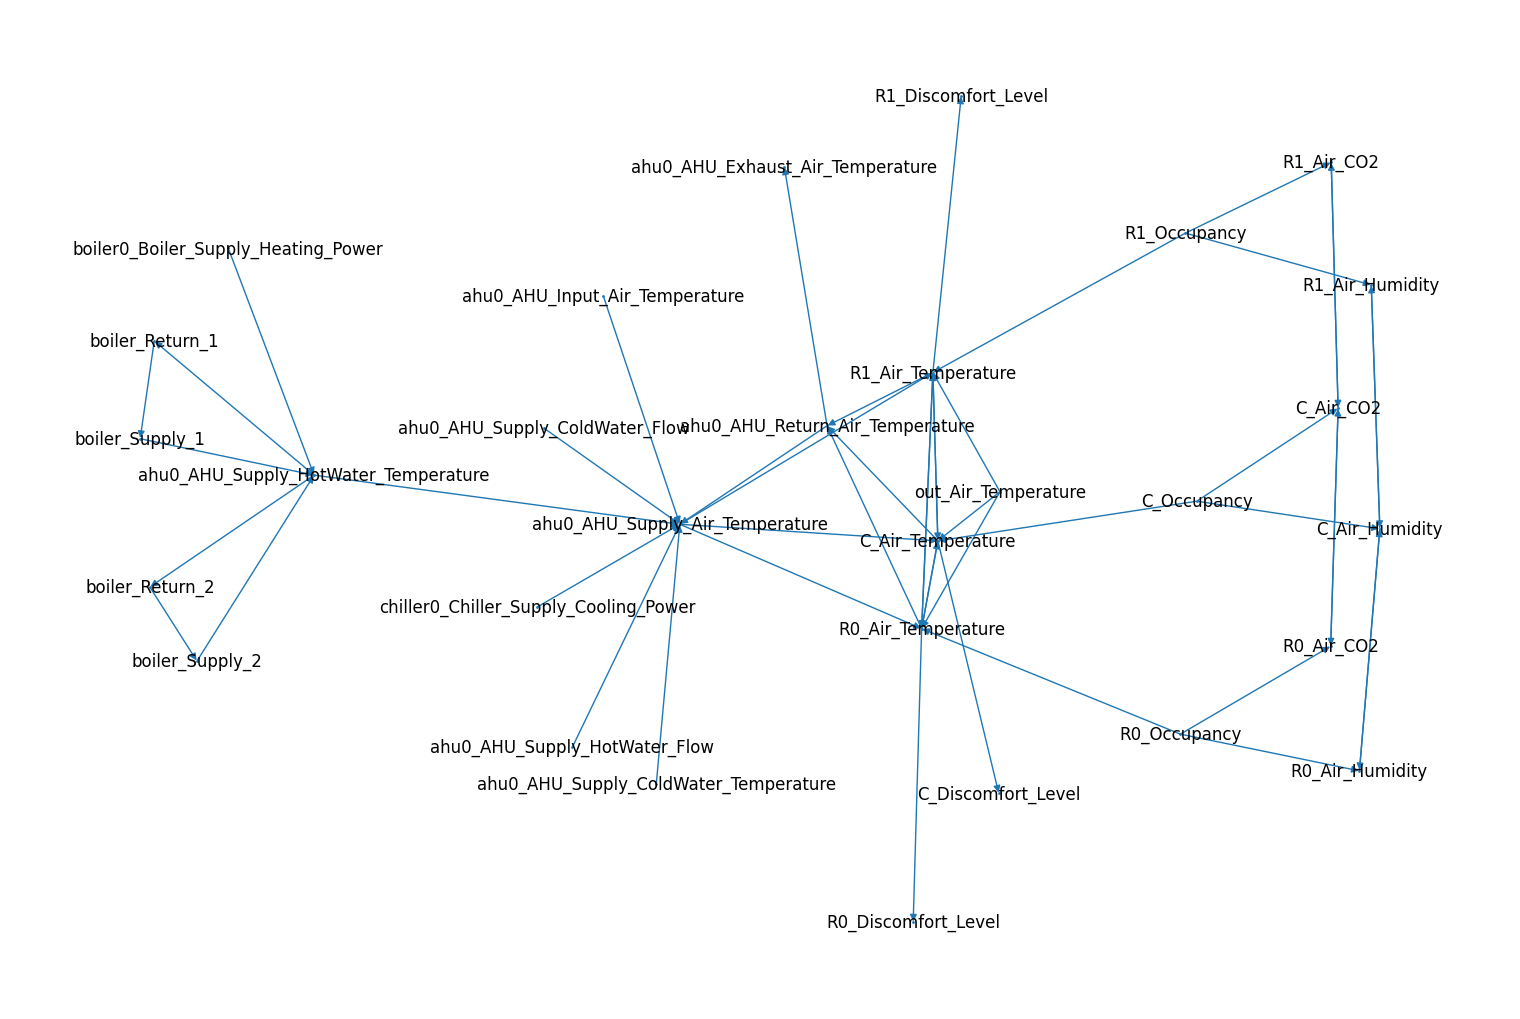

In [8]:
plt.figure(1, figsize=(15,10))
nx.draw(GN, node_size=1, edge_color="tab:blue", pos=pos, with_labels=True, arrows=True)
#nx.draw(GN, node_size=10, edge_color="tab:blue", pos=pos)
plt.savefig("../Plots/GroundTruth.png")

In [9]:
def cluster_plot(G, cluster_map, name, saveto=None):
    for grp,members in cluster_map.items():
        for i in members:
            G.nodes[mapping[i]]['cluster']=grp
            G.nodes[mapping[i]]['color']=cluster_to_color[grp]
    FN = G.__class__()
    FN.add_nodes_from(G)
    TP = G.__class__()
    TP.add_nodes_from(G)
    for e in GN.edges:
        if G.nodes[e[0]]['cluster']==G.nodes[e[1]]['cluster']:
            TP.add_edge(e[0],e[1])
        else:
            FN.add_edge(e[0],e[1])

    ns=100
    plt.figure(figsize=(20,10))
    plt.box(False)
    if 'color' in G.nodes['R0_Air_Temperature']:
        nx.draw_networkx_nodes(G, node_size=ns, node_color=[G.nodes[n]['color'] for n in G.nodes], pos=pos)
    else:
        nx.draw_networkx_nodes(G, node_size=ns, pos=pos)
    nx.draw_networkx_labels(G, pos=pos)
    nx.draw_networkx_edges(TP, node_size=ns, edge_color="tab:green", pos=pos)
    nx.draw_networkx_edges(FN, node_size=ns, edge_color="tab:red", pos=pos)
    #print(len(TP.edges),len(FN.edges))

    plt.legend(handles=[
            Line2D([0], [0], color='green', label=f'Possible {len(TP.edges)}'),
            Line2D([0], [0], color='red', label=f'Impossible {len(FN.edges)}')
    ], loc='lower right', ncols=3)
    plt.title(f"{name}", fontweight="bold")
    if saveto:
        plt.savefig(saveto)

In [10]:
def cluster_plot_ani(G, cluster_maps, name, saveto=None):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.legend(handles=[
        Line2D([0], [0], color='red', label='FP'),
        Line2D([0], [0], color='orange', label='FN'),
        Line2D([0], [0], color='blue', label='TP')
    ], loc='lower right', ncols=3)

    def cluster_plot_(i):
        ax.clear()

        for grp,members in cluster_maps[i].items():
            for i in members:
                G.nodes[mapping[i]]['cluster']=grp
                G.nodes[mapping[i]]['color']=cluster_to_color[grp]
        FN = G.__class__()
        FN.add_nodes_from(G)
        TP = G.__class__()
        TP.add_nodes_from(G)
        for e in GN.edges:
            if G.nodes[e[0]]['cluster']==G.nodes[e[1]]['cluster']:
                TP.add_edge(e[0],e[1])
            else:
                FN.add_edge(e[0],e[1])

        ns=100
        if 'color' in G.nodes['R0_Air_Temperature']:
            nx.draw_networkx_nodes(G, node_size=ns, node_color=[G.nodes[n]['color'] for n in G.nodes], pos=pos)
        else:
            nx.draw_networkx_nodes(G, node_size=ns, pos=pos)
        nx.draw_networkx_labels(G, pos=pos)
        nx.draw_networkx_edges(TP, node_size=ns, edge_color="tab:green", pos=pos)
        nx.draw_networkx_edges(FN, node_size=ns, edge_color="tab:red", pos=pos)

        plt.legend(handles=[
                Line2D([0], [0], color='green', label=f'Possible {len(TP.edges)}'),
                Line2D([0], [0], color='red', label=f'Impossible {len(FN.edges)}')
        ], loc='lower right', ncols=3)
        plt.title(f"{name}", fontweight="bold")

    anim = animation.FuncAnimation(fig, cluster_plot_, frames=len(cluster_maps), interval=200)#, blit=True
    if saveto:
        anim.save(saveto)

In [11]:
# SiVM cluster
tic=datetime.now()
groups,_,_ = mf_clusters(data, n_clusters)
for i in range(n_clusters):
    if len(groups[i]) > 0:
        print(i, groups[i])
toc=datetime.now()

0 [3]
1 [28]
2 [1, 2, 6, 7, 11, 12, 19, 21, 22, 25, 27]
3 [23]
4 [8, 13]
5 [20, 24]
6 [26]
7 [0, 5, 10, 15, 16, 18]
8 [4, 9, 14]
9 [17, 29]


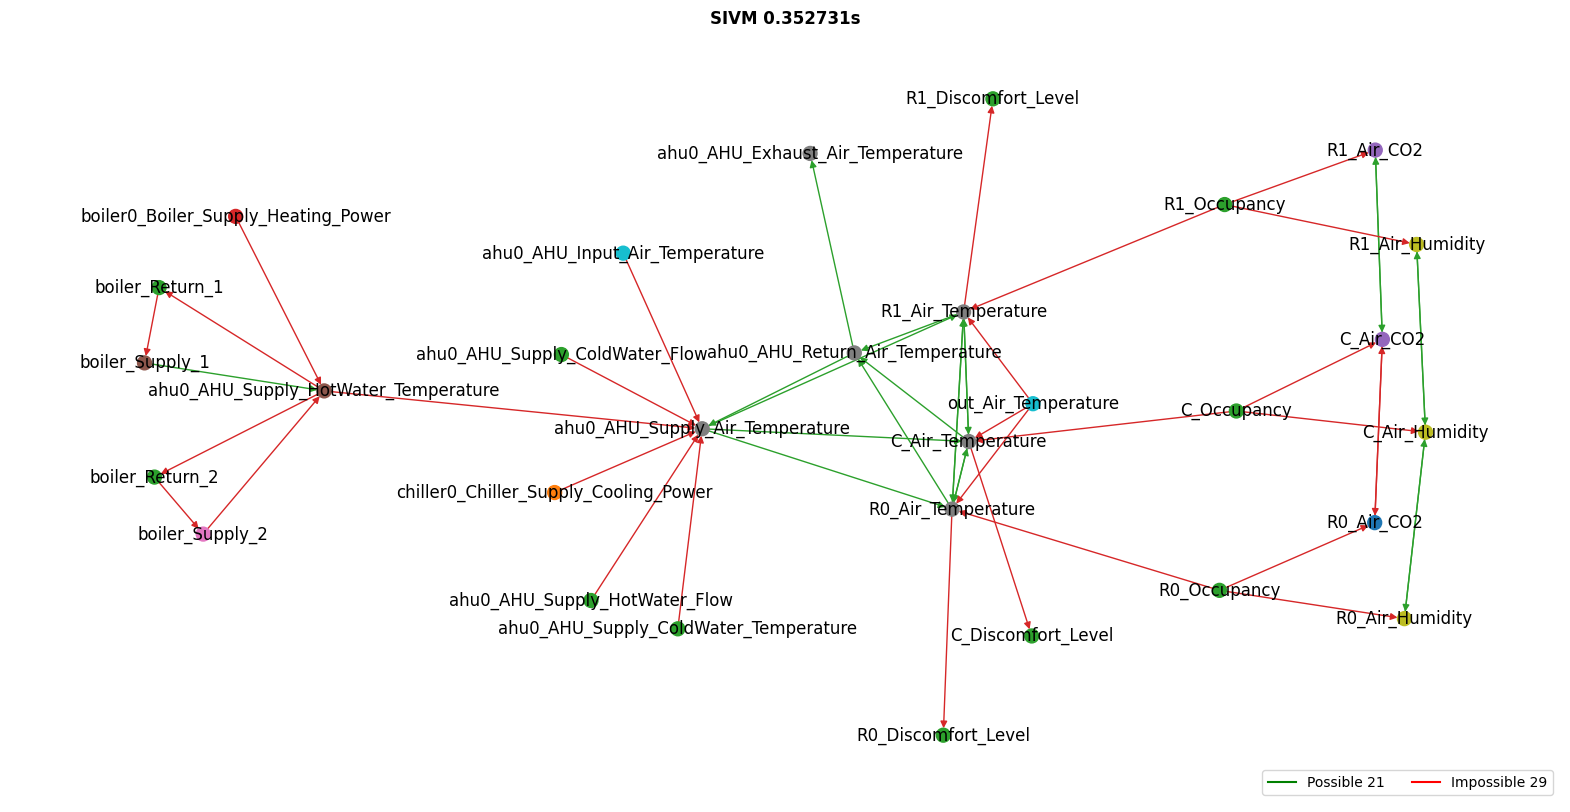

In [12]:
cluster_plot(GN, groups, f"SIVM {(toc - tic).total_seconds()}s", "../Plots/SiVM_All.png")

In [13]:
cluster_maps=[]
tic=datetime.now()
for i, (start, end) in enumerate(zip(periods, periods[1:])):
    cluster_map,_,_=mf_clusters(data[start:end, :], n_clusters)
    cluster_maps.append(cluster_map)
    print(i, cluster_map)
toc=datetime.now()

0 defaultdict(<class 'list'>, {5: [0, 5, 10, 16], 1: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 0: [3], 7: [4, 9, 14], 3: [8, 13], 9: [15], 8: [17, 19, 29], 6: [18], 4: [20, 24, 26], 2: [23]})
1 defaultdict(<class 'list'>, {5: [0, 5, 10, 16], 1: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 0: [3], 7: [4, 9, 14], 3: [8, 13], 9: [15], 8: [17, 19, 29], 6: [18], 4: [20, 24, 26], 2: [23]})
2 defaultdict(<class 'list'>, {8: [0, 5, 10, 16], 1: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 0: [3], 4: [4, 9, 14], 2: [8, 13], 5: [15], 7: [17, 19, 29], 9: [18], 6: [20, 24, 26], 3: [23]})
3 defaultdict(<class 'list'>, {5: [0, 5, 10, 16], 1: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 0: [3], 7: [4, 9, 14], 3: [8, 13], 9: [15], 8: [17, 19, 29], 6: [18], 4: [20, 24, 26], 2: [23]})
4 defaultdict(<class 'list'>, {8: [0, 4, 14], 1: [1, 2, 6, 7, 11, 12, 17, 21, 22, 25, 27, 28, 29], 0: [3], 5: [5, 9, 10, 16], 3: [8, 13], 7: [15], 6: [18], 9: [19], 4: [20, 24, 26], 2: [23]})
5 defaultdict(<class 'list'>, {7: [0, 16

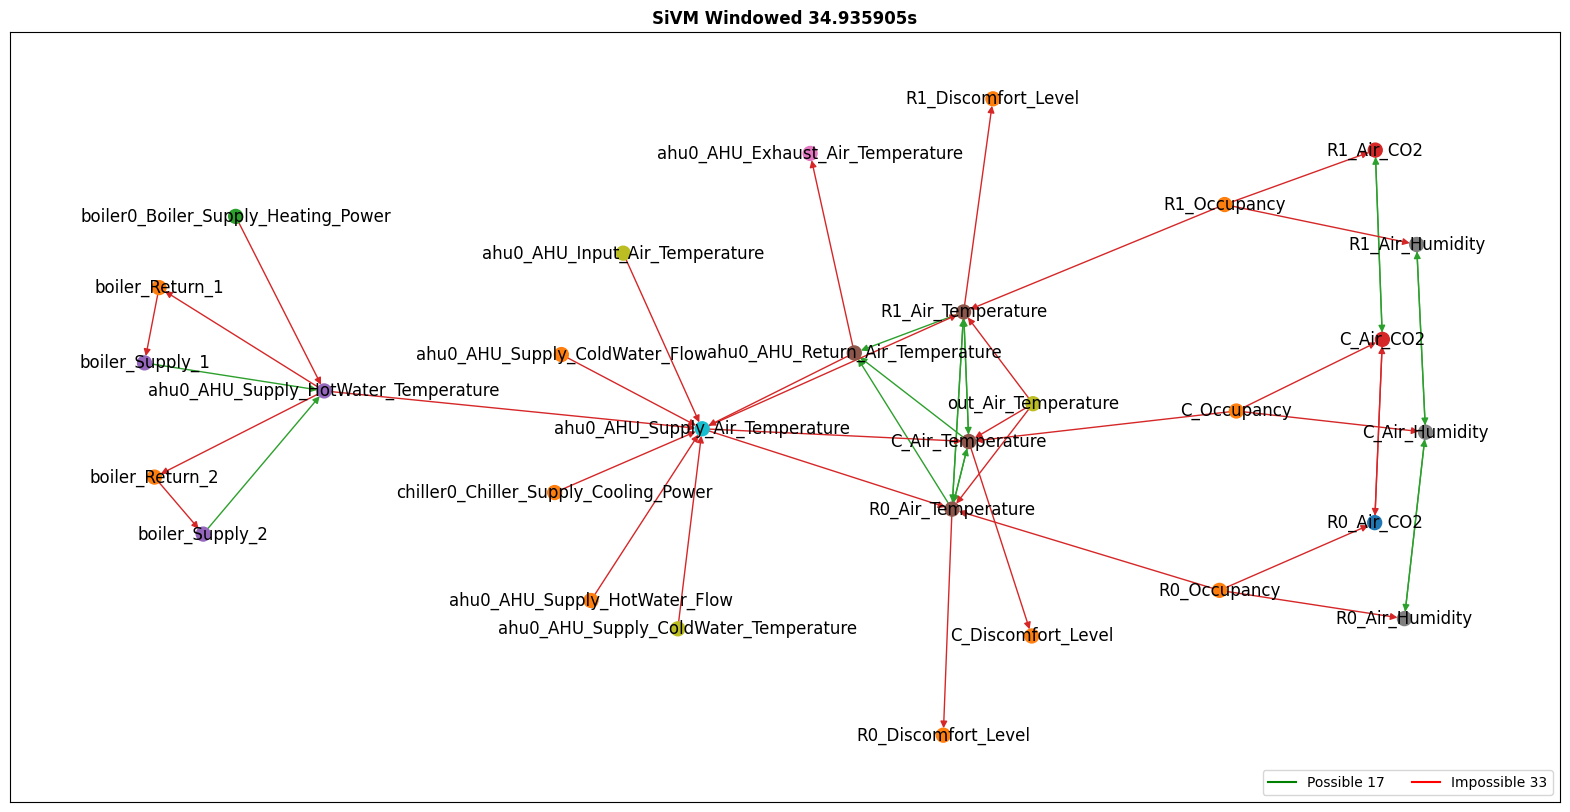

In [14]:
cluster_plot_ani(GN, cluster_maps, f"SiVM Windowed {(toc - tic).total_seconds()}s", saveto="../Plots/SiVM_Windowed.gif")

## KMeans

In [15]:
def cluster_mapping(y_pred):
    cluster_map = defaultdict(list)
    for k, v in {x: y for x, y in zip([x for x in range(len(data[0]))], y_pred)}.items():
        cluster_map[v].append(k)
    return cluster_map

### KMeans with SIVM start

In [16]:
# compute inital cluster centers with 
tic=datetime.now()
cluster_map,mf_centers,_=mf_clusters(data, n_clusters)
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", init=np.array([mf_centers]).transpose(), n_jobs=-1)
y_pred=km.fit_predict(data.transpose())
cluster_map=cluster_mapping(y_pred)
toc=datetime.now()

/Users/jploennigs/miniconda3/envs/causal/lib/python3.9/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 30 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


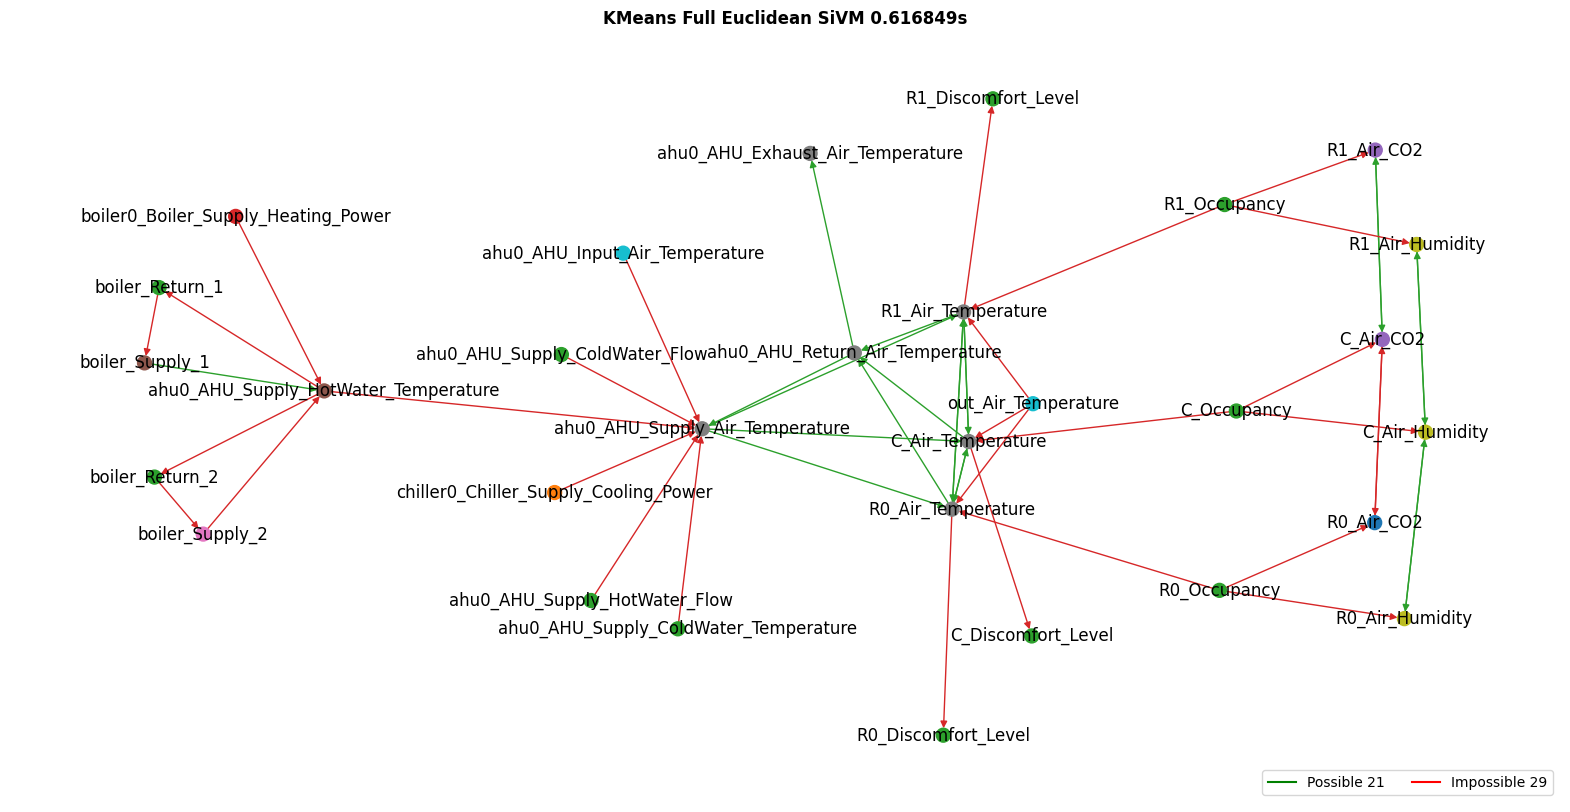

In [17]:
cluster_plot(GN,cluster_map, f"KMeans Full Euclidean SiVM {(toc - tic).total_seconds()}s", "../Plots/KMeans_Full_Eucl_SiVM.png")

### KMeans with Random start

In [18]:
# compute inital cluster centers with 
tic=datetime.now()
cluster_map,mf_centers,_=mf_clusters(data, n_clusters)
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", init=np.array([mf_centers]).transpose(), n_jobs=-1)
y_pred=km.fit_predict(data.transpose())
cluster_map = defaultdict(list)
for k, v in {x: y for x, y in zip([x for x in range(len(data[0]))], y_pred)}.items():
    cluster_map[v].append(k)
toc=datetime.now()

/Users/jploennigs/miniconda3/envs/causal/lib/python3.9/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 30 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


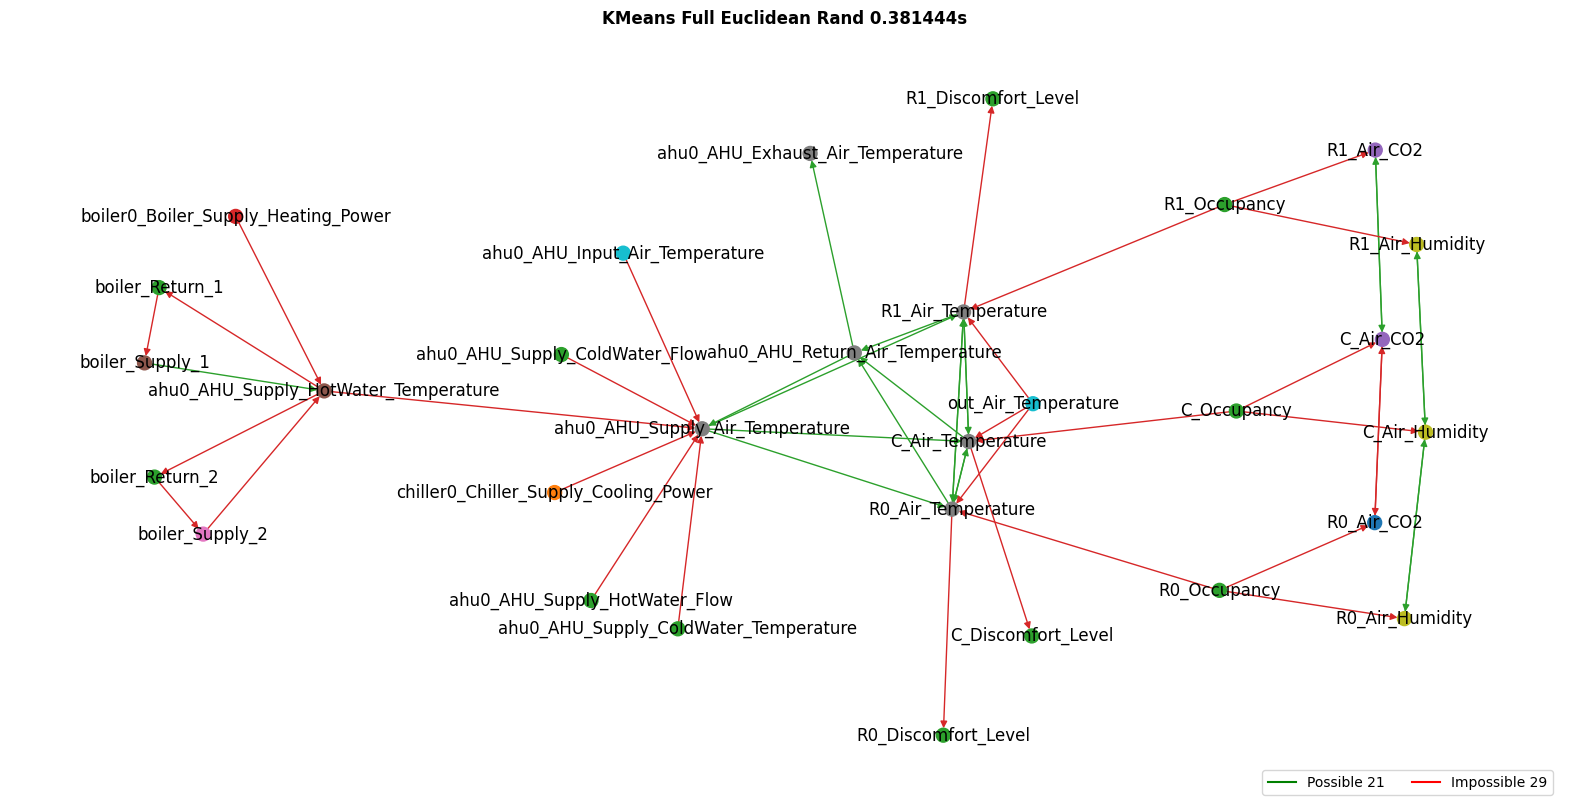

In [19]:
cluster_plot(GN,cluster_map, f"KMeans Full Euclidean Rand {(toc - tic).total_seconds()}s", "../Plots/KMeans_Full_Eucl_Rand.png")

### Euclidean KMeans Consistent

In [20]:
cluster_maps=[]
tic=datetime.now()
for i, (start, end) in enumerate(zip(periods, periods[1:])):
    if i==0:
        km = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=-1)
    else:
        km = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", init=km.cluster_centers_, n_jobs=-1)
    y_pred = km.fit_predict(np.expand_dims(data[start:end, :].transpose(), axis=-1))

    cluster_map = defaultdict(list)
    for k, v in {x: y for x, y in zip([x for x in range(len(data[0]))], y_pred)}.items():
        cluster_map[v].append(k)
    cluster_maps.append(cluster_map)
    print(i, cluster_map)
toc=datetime.now()

0 defaultdict(<class 'list'>, {8: [0, 5, 10, 16], 6: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 3: [3], 4: [4, 9, 14], 1: [8, 13], 7: [15, 18], 9: [17, 29], 0: [19], 5: [20, 24, 26], 2: [23]})
1 defaultdict(<class 'list'>, {8: [0, 5, 10, 16], 6: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 3: [3], 4: [4, 9, 14], 1: [8, 13], 7: [15, 18], 9: [17, 29], 0: [19], 5: [20, 24, 26], 2: [23]})
2 defaultdict(<class 'list'>, {8: [0, 5, 10, 16], 6: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 3: [3], 5: [4, 9, 14, 20, 23, 24, 26], 1: [8, 13], 7: [15, 18], 0: [17, 19, 29]})
3 defaultdict(<class 'list'>, {8: [0, 5, 10, 16], 6: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 3: [3], 4: [4, 9, 14], 1: [8, 13], 7: [15, 18], 9: [17, 29], 0: [19], 5: [20, 24, 26], 2: [23]})
4 defaultdict(<class 'list'>, {8: [0, 4, 5, 9, 10, 14, 16], 6: [1, 2, 6, 7, 11, 12, 17, 21, 22, 25, 27, 28, 29], 3: [3], 1: [8, 13, 23], 7: [15], 0: [18, 19], 5: [20, 24, 26]})
5 defaultdict(<class 'list'>, {8: [0, 4, 5, 10, 16], 6: [1, 2, 6, 7, 1

In [21]:
cluster_plot_ani(GN, cluster_maps, f"KMeans Windowed Euclidean Inc {(toc - tic).total_seconds()}s", saveto="../Plots/KMeans_Windowed_Eucl_Inc.gif")

### DTW KMeans Consistent

In [ ]:
cluster_maps=[]
tic=datetime.now()
for i, (start, end) in enumerate(zip(periods, periods[1:])):
    if i==0:
        km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=-1)
    else:
        km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", init=km.cluster_centers_, n_jobs=-1)
    y_pred = km.fit_predict(np.expand_dims(data[start:end, :].transpose(), axis=-1))

    cluster_map = defaultdict(list)
    for k, v in {x: y for x, y in zip([x for x in range(len(data[0]))], y_pred)}.items():
        cluster_map[v].append(k)
    cluster_maps.append(cluster_map)
    print(i, cluster_map)
toc=datetime.now()

0 defaultdict(<class 'list'>, {0: [0, 5, 10, 16], 4: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 3: [3], 7: [4, 9, 14], 1: [8, 13], 6: [15], 8: [17, 19, 29], 9: [18], 5: [20, 24, 26], 2: [23]})
1 defaultdict(<class 'list'>, {7: [0, 4, 9, 14], 4: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 3: [3], 0: [5, 10, 16], 1: [8, 13], 6: [15], 8: [17, 19, 29], 9: [18], 5: [20, 24, 26], 2: [23]})
2 defaultdict(<class 'list'>, {7: [0], 4: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 3: [3], 5: [4, 9, 14, 20, 23, 24, 26], 0: [5, 10, 16], 1: [8, 13], 6: [15], 8: [17, 19, 29], 9: [18]})
3 defaultdict(<class 'list'>, {7: [0, 4, 9, 14], 4: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 3: [3], 0: [5, 10, 16], 1: [8, 13], 6: [15], 8: [17, 19, 29], 9: [18], 5: [20, 24, 26], 2: [23]})
4 defaultdict(<class 'list'>, {7: [0, 4], 4: [1, 2, 6, 7, 11, 12, 17, 21, 22, 25, 27, 28, 29], 3: [3], 0: [5, 9, 10, 14, 16], 1: [8, 13, 23], 6: [15], 9: [18], 8: [19], 5: [20, 24, 26]})
5 defaultdict(<class 'list'>, {7: [0, 4], 4: [1, 2

KeyboardInterrupt: 

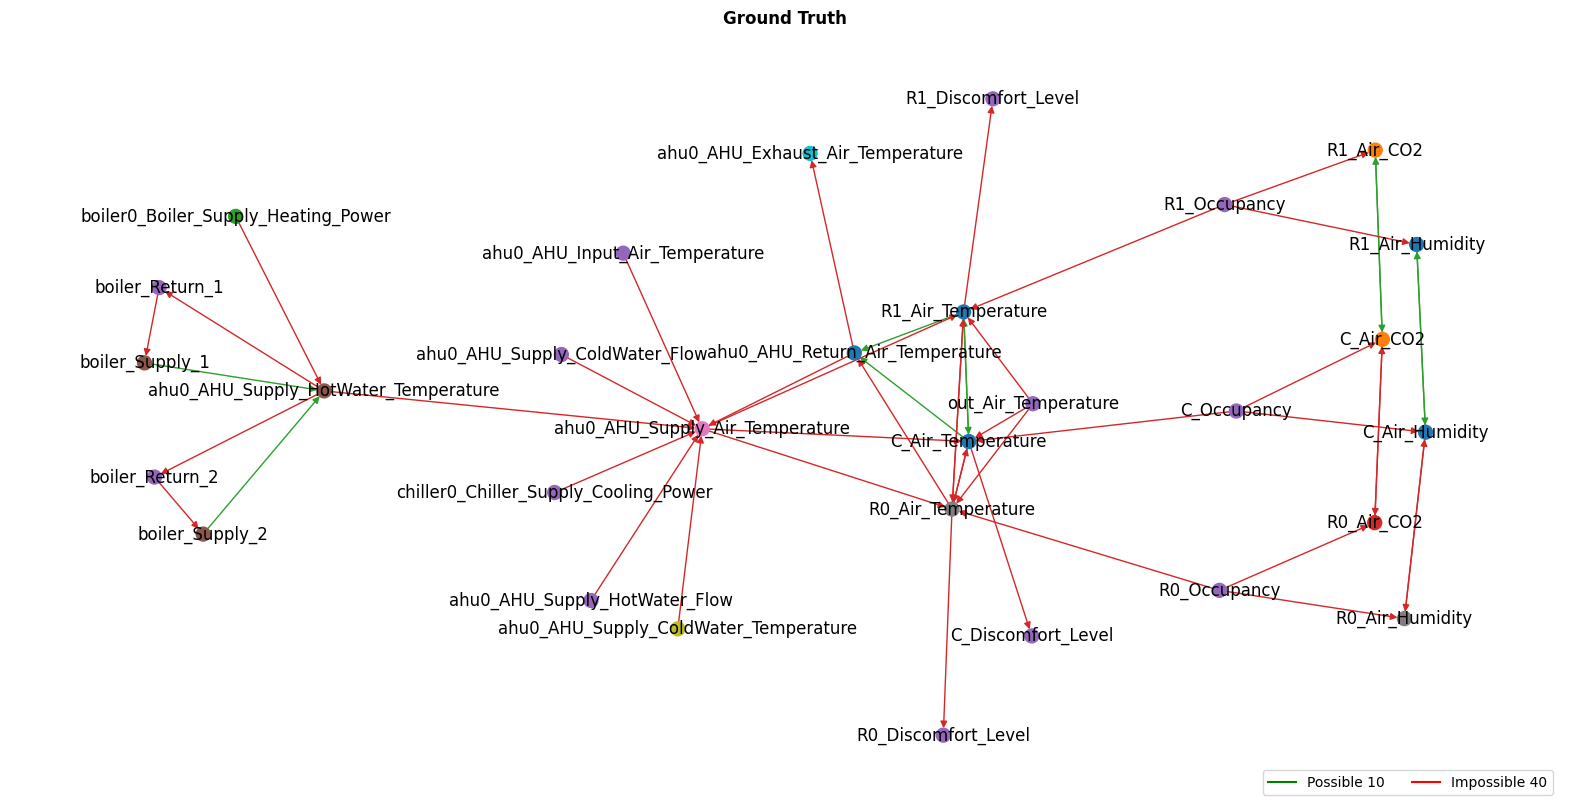

In [ ]:
cluster_plot_ani(GN, cluster_maps, f"KMeans Windowed DTW Inc {(toc - tic).total_seconds()}s", saveto="../Plots/KMeans_Windowed_DTW_Inc.gif")

### DTW KMeans Random

In [ ]:
tic=datetime.now()
for i, (start, end) in enumerate(zip(periods, periods[1:])):
    km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=-1)
    y_pred = km.fit_predict(np.expand_dims(data[start:end, :].transpose(), axis=-1))

    cluster_map = defaultdict(list)
    for k, v in {x: y for x, y in zip([x for x in range(len(data[0]))], y_pred)}.items():
        cluster_map[v].append(k)
    print(i, cluster_map)
toc=datetime.now()

0 {4: [0, 5, 10, 16], 0: [1, 2, 6, 7, 11, 12, 17, 21, 22, 25, 27, 28, 29], 2: [3], 9: [4, 9, 14], 1: [8, 13], 8: [15], 6: [18], 7: [19], 5: [20, 24, 26], 3: [23]}
1 {4: [0, 5, 10, 16], 6: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 3: [3], 8: [4, 9, 14], 1: [8, 13], 7: [15], 0: [17, 19, 29], 9: [18], 5: [20, 24, 26], 2: [23]}
2 {0: [0], 4: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 2: [3], 5: [4, 9, 14], 9: [5, 10, 16], 1: [8, 13], 6: [15, 18], 7: [17, 19, 29], 8: [20, 24, 26], 3: [23]}
3 {7: [0, 5, 10, 16], 4: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 3: [3], 0: [4, 9, 14], 1: [8, 13], 8: [15], 9: [17, 19, 29], 6: [18], 5: [20, 24, 26], 2: [23]}
4 {9: [0, 4, 9, 14], 4: [1, 2, 6, 7, 11, 12, 17, 21, 22, 25, 27, 28, 29], 0: [3], 1: [5, 10, 16], 2: [8, 13], 7: [15], 6: [18], 8: [19], 5: [20, 24, 26], 3: [23]}
5 {0: [0, 4, 5, 10, 16], 4: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 2: [3], 3: [8, 13], 6: [9, 14, 15], 7: [17, 29], 9: [18], 8: [19], 5: [20, 24, 26], 1: [23]}
6 {4: [0, 5, 10, 16], 

In [ ]:
cluster_plot_ani(GN, cluster_maps, f"KMeans Windowed DTW Rand {(toc - tic).total_seconds()}s", saveto="../Plots/KMeans_Windowed_DTW_Rand.gif")

### SoftDTW KMeans Random

In [ ]:
tic=datetime.now()
for i, (start, end) in enumerate(zip(periods, periods[1:])):
    km = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", n_jobs=-1)
    y_pred = km.fit_predict(np.expand_dims(data[start:end, :].transpose(), axis=-1))

    cluster_map = defaultdict(list)
    for k, v in {x: y for x, y in zip([x for x in range(len(data[0]))], y_pred)}.items():
        cluster_map[v].append(k)
    print(i, cluster_map)
toc=datetime.now()

0 {8: [0, 5, 10, 16], 5: [1, 2, 6, 7, 11, 12, 17, 21, 22, 25, 27, 28, 29], 3: [3], 6: [4, 9, 14], 1: [8, 13], 7: [15], 0: [18], 9: [19], 4: [20, 24, 26], 2: [23]}
1 {5: [0, 5, 10, 16], 6: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 2: [3], 7: [4, 9, 14], 1: [8, 13], 8: [15], 4: [17, 19, 29], 9: [18], 0: [20, 24, 26], 3: [23]}
2 {3: [0], 4: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 2: [3], 5: [4, 9, 14], 9: [5, 10, 16], 1: [8, 13], 6: [15, 18], 7: [17, 19, 29], 8: [20, 24, 26], 0: [23]}
3 {4: [0, 5, 10, 16], 0: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 3: [3], 7: [4, 9, 14], 1: [8, 13], 8: [15], 9: [17, 19, 29], 6: [18], 5: [20, 24, 26], 2: [23]}
4 {9: [0, 4, 9, 14], 4: [1, 2, 6, 7, 11, 12, 17, 21, 22, 25, 27, 28, 29], 2: [3], 5: [5, 10, 16], 1: [8, 13], 7: [15], 6: [18], 8: [19], 0: [20, 24, 26], 3: [23]}
5 {9: [0], 7: [1, 2, 6, 7, 11, 12, 21, 22, 25, 27, 28], 2: [3], 5: [4, 5, 10, 16], 0: [8, 13], 8: [9, 14, 15], 6: [17, 29], 1: [18, 19], 4: [20, 24, 26], 3: [23]}
6 {9: [0], 1: [1, 2, 6

KeyboardInterrupt: 